<center> <h1> HireScore </h1> </center>  

**Predicting Student Placement & Salary Outcomes with Machine Learning**

---

### Project Summary  
This notebook explores how academic performance, technical skills, and extracurricular involvement influence engineering students' placement success and salary offers (CTC in LPA).  
We develop two supervised ML models:
- A **classification model** to predict whether a student will be placed
- A **regression model** to estimate the expected CTC (salary) for placed students




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##  Dataset Info

**Source:** [Engineering Student Journey – Kaggle](https://www.kaggle.com/datasets/rakeshkapilavai/engineering-student-journey)  
**Author:** Rakesh Kapilavayi  
**Updated:** ~20 days ago  
**File:** `students.csv`

---

In [2]:
df = pd.read_csv("./data/students.csv")
df.columns

Index(['Student ID', 'Name', 'Age', 'Gender', 'Branch', 'Average GPA',
       'Backlogs', 'Attendance (%)', 'Clubs', 'Skills', 'Internship Done',
       'Internship Domain', 'Placement Status', 'Placement Domain',
       'CTC (LPA)', 'Alumni Path', 'Sem1 GPA', 'Sem2 GPA', 'Sem3 GPA',
       'Sem4 GPA', 'Sem5 GPA', 'Sem6 GPA', 'Sem7 GPA', 'Sem8 GPA'],
      dtype='object')

##  Data Cleaning & Feature Engineering

- Parsed comma-separated `Skills` and `Clubs` into list format
- One-hot encoded `Branch` and `Gender`
- Transformed features like `Skills` and `Clubs` into counts
- Dropped unused columns like individual semester GPAs except for Sem7
- Normalized `Attendance (%)` and `Average GPA`
- Created separate datasets for:
  -  Regression (for predicting CTC)
  -  Classification (for predicting Placement Status)

---

In [3]:
df["Skills"] = df["Skills"].map(lambda x: [s.strip() for s in x.split(",")])
df["Clubs"] = df["Clubs"].map(lambda x: [c.strip() for c in x.split(",")])
df["GPA_Trend"] = df["Sem8 GPA"] - df["Sem1 GPA"]

branches, skills, clubs = [], [], []
for index, row in df.iterrows():
    for skill in row["Skills"]:
        skills.append(skill)
    for club in row["Clubs"]:
        clubs.append(club)

branches = df["Branch"].unique()
skills = set(skills)
clubs = set(clubs)

In [4]:
df_cleaned = pd.get_dummies(df, columns=["Branch", "Gender"], drop_first=True)
df_cleaned["Skills"] = df_cleaned["Skills"].map(lambda x: len(x))
df_cleaned["Clubs"] = df_cleaned["Clubs"].map(lambda x: len(x))
df_cleaned.drop(columns=["Age", "Sem1 GPA", "Sem2 GPA","Sem3 GPA","Sem4 GPA","Sem5 GPA","Sem7 GPA", "Sem8 GPA", "Gender_Male"], inplace=True)
df_cleaned["Internship Done"] = df_cleaned["Internship Done"].map(lambda x: True if x == "Yes" else False)
df_cleaned["Attendance (%)"] = (df_cleaned["Attendance (%)"] - df_cleaned["Attendance (%)"].mean())/df_cleaned["Attendance (%)"].std()
df_cleaned["Average GPA"] = (df_cleaned["Average GPA"] - df_cleaned["Average GPA"].mean())/df_cleaned["Average GPA"].std()

In [5]:
data_regression = df_cleaned.drop(columns=["Student ID", "Internship Domain", "Placement Domain", "Name", "Alumni Path"])
data_regression = data_regression[data_regression["Placement Status"] == "Placed"]
data_regression.drop(columns=["Placement Status"], inplace=True)
data_classification = df_cleaned.drop(columns=["Student ID", "Internship Domain", "Placement Domain", "Name", "Alumni Path", "CTC (LPA)"])
data_classification["Placement Status"] = data_classification["Placement Status"].map(lambda x: 1 if x == "Placed" else 0)

In [6]:
data_classification

,Average GPA,Backlogs,Attendance (%),Clubs,Skills,Internship Done,Placement Status,Sem6 GPA,GPA_Trend,Branch_CSE,Branch_ECE,Branch_EEE,Branch_IT,Branch_MECH
0,-0.036982,0,-0.723144,2,4,True,0,7.04,-2.35,False,False,False,False,True
1,-1.590560,0,-1.149367,2,3,False,0,6.99,-1.85,False,True,False,False,False
2,0.226833,0,0.499266,1,3,True,0,6.01,0.83,False,False,False,False,False
3,-0.242171,2,-1.421298,2,3,False,1,6.80,-0.47,False,True,False,False,False
4,0.256146,0,1.550333,1,4,True,0,6.18,1.68,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,2.014913,2,1.152240,3,5,True,0,7.15,0.53,False,False,False,True,False
1995,0.725151,0,1.484695,2,4,False,0,5.91,1.51,False,False,False,False,False
1996,-0.242171,0,-0.308002,2,3,True,0,6.70,1.65,False,False,True,False,False
1997,0.256146,0,1.301419,3,5,True,1,6.71,-1.31,True,False,False,False,False


## Classification Task: Will the student get placed?

We train two models on the same data:
- **Logistic Regression**
- **Random Forest Classifier**

---

In [7]:
from sklearn.model_selection import train_test_split
X_classification = data_classification.drop(columns=["Placement Status"])
y_classification = data_classification["Placement Status"]
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_clas, y_train_clas)
print(f"Accuracy: {lr.score(X_test_clas, y_test_clas)}")

Accuracy: 0.5025


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_clas, y_train_clas)
print(f"Accuracy: {rf.score(X_test_clas, y_test_clas)}")

Accuracy: 0.88


## 🧾 Model Comparison Summary

| Model              | Accuracy | Notes                                 |
|-------------------|----------|----------------------------------------|
| Logistic Regression | 50%     | Underfitting, linear boundary issues   |
| Random Forest       | 89%     | Nonlinear, robust to mixed features    |


In [10]:
feature_names = X_train_clas.columns
lr_feature_importance = lr.coef_.flatten()
rf_feature_importance = rf.feature_importances_

##  Feature Importance: Logistic Regression vs Random Forest

> Feature importances visualized side-by-side for both models

---

<Figure size 1000x800 with 0 Axes>

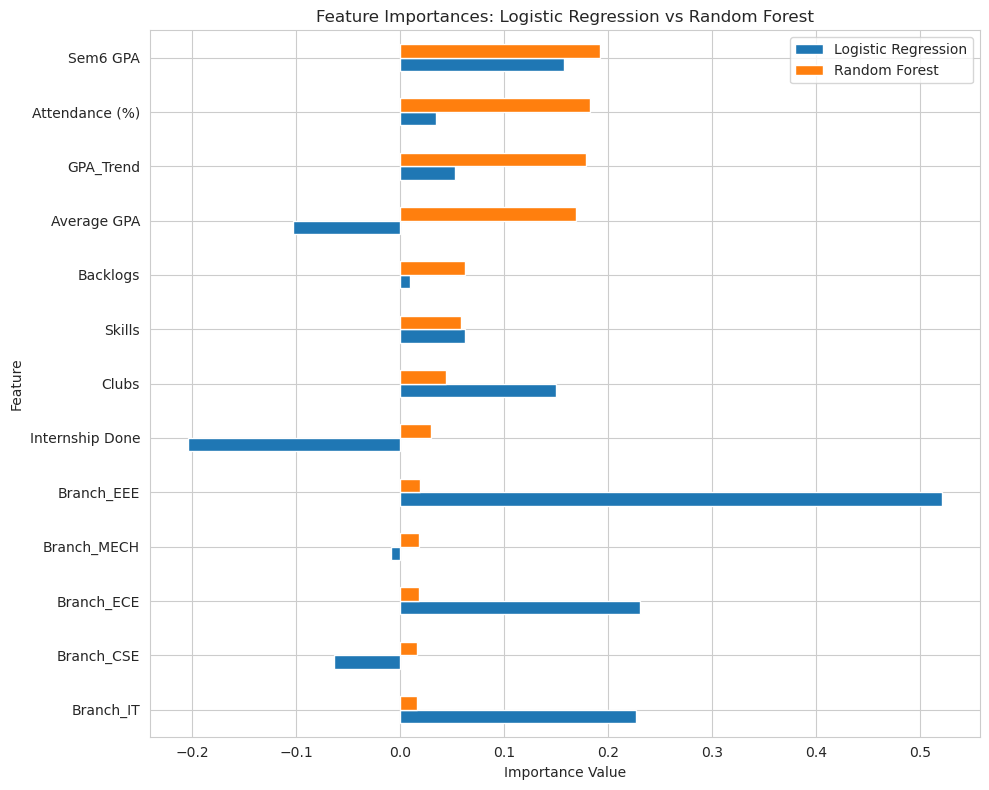

In [11]:
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic Regression": lr_feature_importance,
    "Random Forest": rf_feature_importance
})

# Optional: Sort by Random Forest importance for better visual clarity
importance_df = importance_df.sort_values(by="Random Forest", ascending=True)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Horizontal bar chart
importance_df.set_index("Feature").plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances: Logistic Regression vs Random Forest")
plt.xlabel("Importance Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Important Highlights from Classification

1. **Random Forest massively outperforms Logistic Regression**, suggesting that the relationship between student features and placement success is **non-linear**.
2. **Top Influential Features**:
    - Sem6 SGPA 📈
    - Attendance (%) 📈
    - Overall CGPA 📈
    - Backlogs 📉
3. Logistic Regression gave very high weight to **Branch**, whereas Random Forest gave it low importance.  
   → **Conclusion:** Branch likely isn't a key determinant for placement success.

---

## Regression Task: Predicting Salary (CTC in LPA)

In this section, we predict the **expected CTC (in LPA)** for students who were placed using supervised regression models. 

We evaluate both:
-  **Linear Regression** (assumes a linear relationship between features and CTC)
-  **Random Forest Regressor** (a nonlinear, ensemble-based method)

---

In [12]:
X_regression = data_regression.drop(columns=["CTC (LPA)"])
y_regression = data_regression["CTC (LPA)"]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

In [13]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()
lreg.fit(X_train_reg, y_train_reg)
print(f"R2: {lreg.score(X_test_reg, y_test_reg)}")

R2: -0.025523870931782433


In [14]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor()
rfreg.fit(X_train_reg, y_train_reg)
print(f"R2: {rfreg.score(X_test_reg, y_test_reg)}")

R2: 0.5625396426908299


###  Model Results

| Model                 | R² Score | Notes                                               |
|----------------------|----------|-----------------------------------------------------|
| Linear Regression     | ~0.00    | Model fails to learn patterns; underfits completely |
| Random Forest Regressor | ~0.54    | Captures important nonlinear relationships in data  |

---

In [15]:
feature_names = X_train_reg.columns
lreg_feature_importance = lreg.coef_.flatten()
rfreg_feature_importance = rfreg.feature_importances_

<Figure size 1000x800 with 0 Axes>

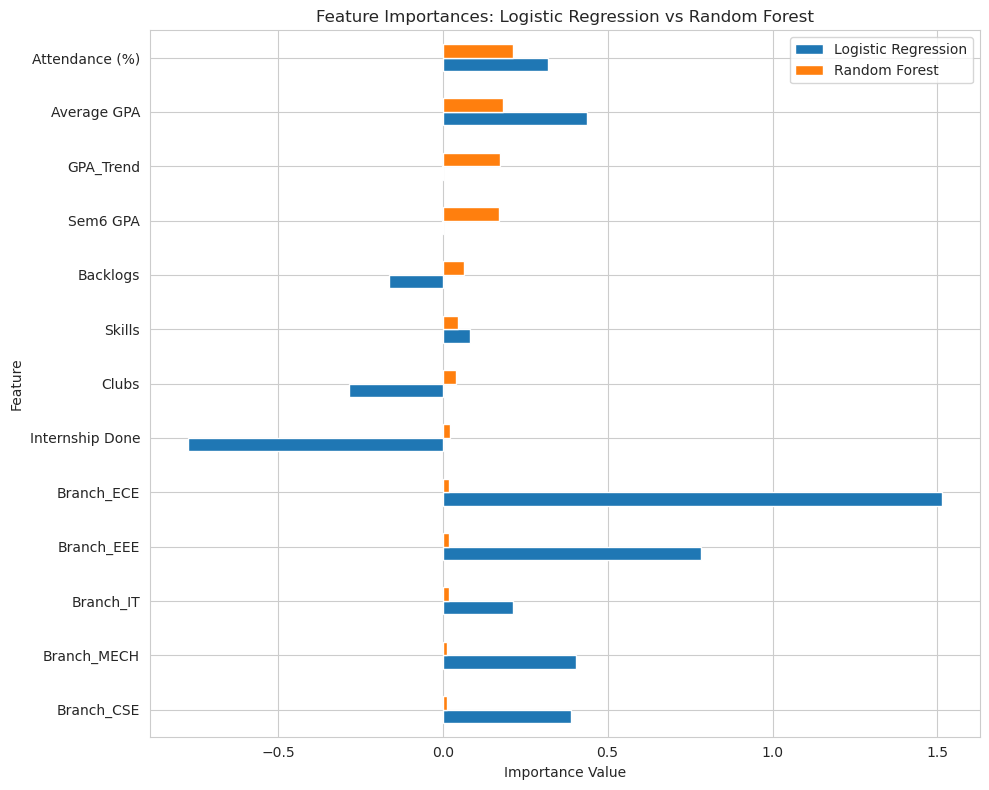

In [16]:
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic Regression": lreg_feature_importance,
    "Random Forest": rfreg_feature_importance
})

# Optional: Sort by Random Forest importance for better visual clarity
importance_df = importance_df.sort_values(by="Random Forest", ascending=True)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Horizontal bar chart
importance_df.set_index("Feature").plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances: Logistic Regression vs Random Forest")
plt.xlabel("Importance Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 📊 Key Feature Insights (CTC Prediction)

Based on feature importance from Random Forest:
- ✅ **CGPA and SGPA** → Strongest positive correlation with higher salary
- ✅ **GPA Trend** (improvement over semesters) → Indicates growth
- ✅ **Attendance (%)** → Consistently relevant
- ✅ **Internship Done** → Boosts salary potential
- ❌ **Backlogs** → Negatively impact offers

> Linear Regression struggled due to inability to model interactions and nonlinearity, while Random Forest captured more realistic patterns in salary distribution.

---

##  Final Conclusion

---

###  Summary of Findings:

- **Placement Prediction** (Classification):
  - Random Forest achieved **~89% accuracy**
  - Academic consistency, attendance, and fewer backlogs were strong predictors

- **Salary Prediction** (Regression):
  - Random Forest Regressor achieved **R² ≈ 0.54**
  - Indicates a meaningful but imperfect relationship between input features and salary outcomes
  - Linear regression failed, suggesting the need for nonlinear modeling

---

###  Takeaways:

- **Academic performance**, while important, is **not the only factor** — skills, internships, and consistency matter
-  **Nonlinear models** like Random Forest outperform simpler approaches on real-world education data
-  With deeper feature engineering and better data (like company-wise offers or resume quality), performance could further improve

---


Exporting Models

In [17]:
import pickle

with open("classification_rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("regression_rf_model.pkl", "wb") as f:
    pickle.dump(rfreg, f)